In [ ]:
!pip install -q mediapy
%cd /kaggle/working/
!rm -rf /kaggle/working/Hierarchical-Localization
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
%cd /kaggle/working/Hierarchical-Localization
!pip install -e .

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

%cd /kaggle/working/
from pathlib import Path

import cv2
import mediapy
import pandas as pd
import plotly.express as px
import pycolmap

In [ ]:
!pip install --no-index /kaggle/input/imc2024-packages-lightglue-rerun-kornia/* --no-deps
!mkdir -p /root/.cache/torch/hub/checkpoints
!cp /kaggle/input/aliked/pytorch/aliked-n16/1/* /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/* /root/.cache/torch/hub/checkpoints/
!cp /kaggle/input/lightglue/pytorch/aliked/1/aliked_lightglue.pth /root/.cache/torch/hub/checkpoints/aliked_lightglue_v0-1_arxiv-pth

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
from glob import glob
import shutil
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from time import time, sleep
from fastprogress import progress_bar
import h5py
from IPython.display import clear_output
from collections import defaultdict
from copy import deepcopy

import torch
import torch.nn.functional as F
import kornia as K
import kornia.feature as KF
from PIL import Image
from transformers import AutoImageProcessor, AutoModel

from lightglue import match_pair
from lightglue import LightGlue, ALIKED, SuperPoint
from lightglue.utils import load_image, rbd

import sys
sys.path.append('/kaggle/input/colmap-db-import')
from database import *
from h5_to_db import *

In [4]:
dataset = 'church'
path_dataset = f'/kaggle/input/image-matching-challenge-2024/train/{dataset}'

images = [cv2.cvtColor(cv2.imread(im), cv2.COLOR_BGR2RGB) for im in glob(f'{path_dataset}/images/*')][8:12]

,,,

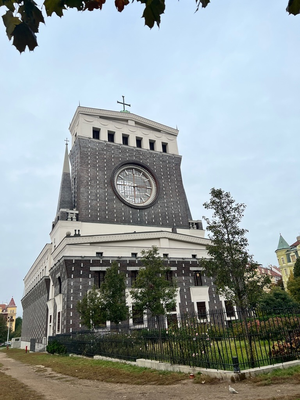
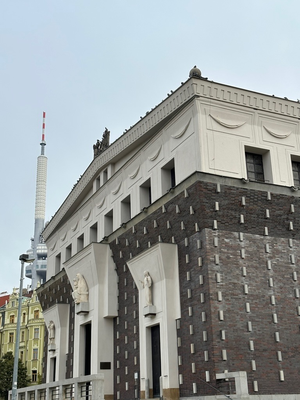
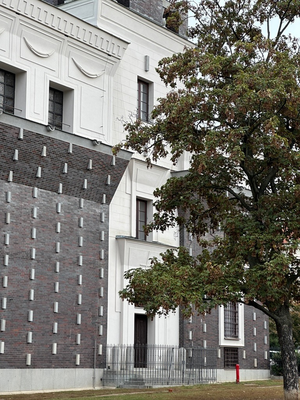
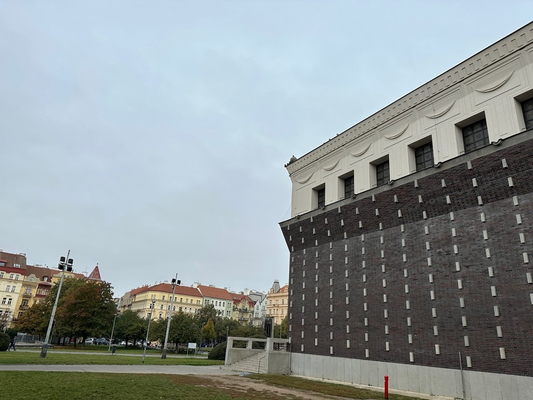

In [5]:
mediapy.show_images(images, height=400, columns=4)

## Visualizing a Colmap reconstruction

In [ ]:
rec_gt = pycolmap.Reconstruction(f'{path_dataset}/sfm')

fig = viz_3d.init_figure()
viz_3d.plot_cameras(fig, rec_gt, color='rgba(50,255,50, 0.5)', name="Ground Truth", size=10)
viz_3d.plot_reconstruction(fig, rec_gt, cameras = False, color='rgba(255,50,255, 0.5)', name="Ground Truth", cs=5)
fig.show()

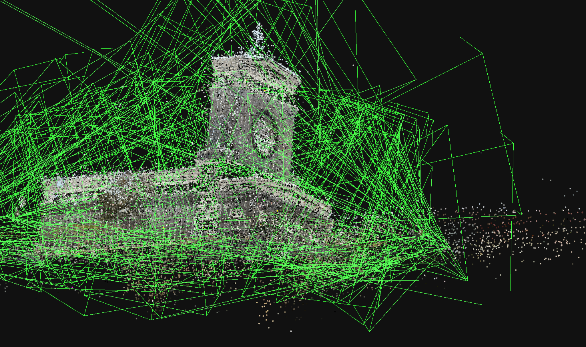 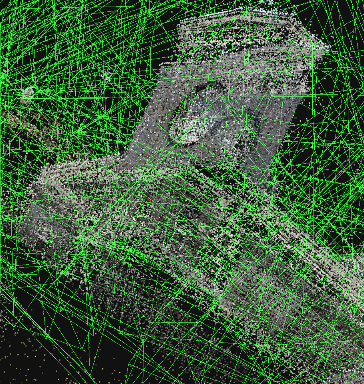

## Generate a simple reconstruction with SIFT

In [ ]:
tgt = f'/kaggle/working/{dataset}'

if not os.path.isdir(tgt):
    os.makedirs(f'{tgt}/bundle')
    os.system(f'cp -r {path_dataset}/images {tgt}/images')

    database_path = f'{tgt}/database.db'

    sift_opt = pycolmap.SiftExtractionOptions()
    sift_opt.max_image_size = 1500  
    sift_opt.max_num_features = 8192  
    sift_opt.upright = True 
    device = 'cpu'
    
    pycolmap.extract_features(database_path, f'{tgt}/images', sift_options=sift_opt)
    print(len(os.listdir(f'{tgt}/images')))


    matching_opt = pycolmap.SiftMatchingOptions()
    matching_opt.max_ratio = 0.85 
    matching_opt.cross_check = True
    pycolmap.match_exhaustive(database_path, sift_options=matching_opt, device=device)


    mapper_options = pycolmap.IncrementalPipelineOptions()
    mapper_options.min_model_size = 3

    mapper_options.init_image_id1 = -1 
    mapper_options.init_image_id2 = -1

    mapper_options.ba_refine_focal_length = True
    mapper_options.ba_refine_principal_point = True
    mapper_options.ba_refine_extra_params = True

    maps = pycolmap.incremental_mapping(database_path=database_path, image_path=f'{tgt}/images', output_path=f'{tgt}/bundle', options=mapper_options)

In [ ]:
best_index = None
best_num_reg_images = 0
for idx in maps:
    if maps[idx].num_reg_images() > best_num_reg_images:
        best_index = idx
        best_num_reg_images = maps[idx].num_reg_images()

if best_num_reg_images > 0:
    print(f'Looking at reconstruction #{best_index} with {best_num_reg_images} registered images')

    fig = viz_3d.init_figure()
    viz_3d.plot_reconstruction(fig, maps[best_index], color='rgba(0,0,255,0.5)', name="Reconstruction", cs=5, cameras=False)
    viz_3d.plot_reconstruction(fig, maps[best_index], color='rgba(255,0,0,0.5)', name="Reconstruction", cs=5, points=False)
    fig.show()
else:
    print('No reconstruction.')

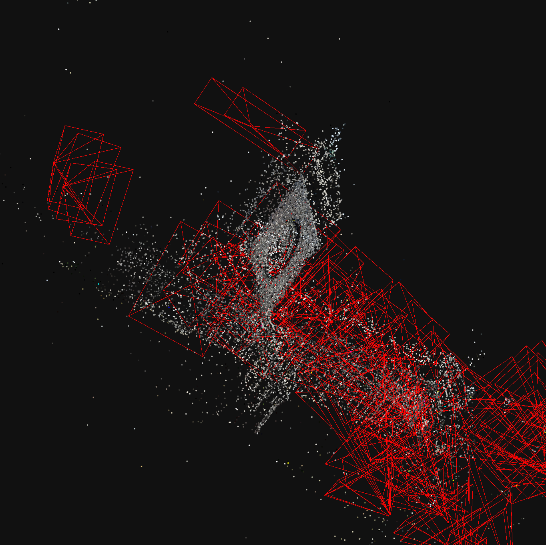

In [9]:
def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() / 255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

## Generate reconstruction with ALIKED

In [10]:
def detect_keypoints(paths: list[Path], num_features: int = 4096, device=torch.device('cpu'),
                     feature_dir = '.featureout'):
    
    dtype = torch.float32
    
    extractor = ALIKED(max_num_keypoints=num_features, 
                      detection_threshold=0.01, resize=1280).eval().to(device, dtype)
    
    if not os.path.isdir(feature_dir):
        os.makedirs(feature_dir)
    
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_keypoints, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='w') as f_descriptors:
        for img_path in progress_bar(paths):
            key = img_path.split('/')[-1]
            with torch.inference_mode():
                image = load_torch_image(img_path, device=device).to(dtype)
                features = extractor.extract(image)
                f_keypoints[key] = features['keypoints'].reshape(-1, 2).detach().cpu().numpy()
                f_descriptors[key] = features['descriptors'].reshape(len(f_keypoints[key]), -1).detach().cpu().numpy()

image_paths = [file_name for file_name in glob(f'{path_dataset}/images/*')]
feature_dir = 'aliked_features'
device = torch.device('cuda')
detect_keypoints(image_paths, 5000, device=device, feature_dir=feature_dir)

In [11]:
def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout',
                   device=torch.device('cpu'),
                   min_matches=15, verbose = True):
    with h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_desc, \
         h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
                    idx1, idx2 = pair_idx
                    fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
                    key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                    desc1 = torch.from_numpy(f_desc[key1][...]).to(device)
                    desc2 = torch.from_numpy(f_desc[key2][...]).to(device)

                    dists, idxs = KF.match_smnn(desc1, desc2, 0.98)
                    if len(idxs)  == 0:
                        continue
                    n_matches = len(idxs)
                    if verbose:
                        print (f'{key1}-{key2}: {n_matches} matches')
                    group  = f_match.require_group(key1)
                    if n_matches >= min_matches:
                         group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))

In [12]:
def keypoint_distances(paths: list[Path], index_pairs: list[tuple[int, int]], 
                       feature_dir: Path, min_matches: int = 15,
                       verbose: bool = False, device: torch.device = torch.device('cpu')) -> None:
    
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='r') as f_keypoints, \
         h5py.File(f'{feature_dir}/descriptors.h5', mode='r') as f_descriptors,\
         h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_matches:
            for pair_idx in progress_bar(index_pairs):
                    idx1, idx2 = pair_idx
                    fname1, fname2 = paths[idx1], paths[idx2]
                    key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
                    desc1 = torch.from_numpy(f_descriptors[key1][...]).to(device)
                    desc2 = torch.from_numpy(f_descriptors[key2][...]).to(device)
                    dists, idxs = KF.match_smnn(desc1, desc2, 0.98)
                    if len(idxs)  == 0:
                        continue
                    n_matches = len(idxs)
                    if verbose:
                        print (f'{key1}-{key2}: {n_matches} matches')
                    group  = f_matches.require_group(key1)
                    if n_matches >= min_matches:
                         group.create_dataset(key2, data=idxs.detach().cpu().numpy().reshape(-1, 2))

index_pairs = []
for i in range(len(image_paths)):
    for j in range(i+1, len(image_paths)):
        index_pairs.append((i,j))

keypoint_distances(image_paths, index_pairs, device=torch.device('cuda'), feature_dir=feature_dir)

In [13]:
database_path = f'{tgt}/database_aliked.db'
!rm -rf {database_path}
image_dir = f'{path_dataset}/images'

import_into_colmap(image_dir, database_path=database_path, feature_dir=feature_dir)

100%|██████████| 111/111 [00:03<00:00, 31.81it/s]
6105it [00:01, 3566.17it/s]                          


In [ ]:
output_path =  f'{tgt}/disk_reconstruction'
os.makedirs(output_path, exist_ok=True)
pycolmap.match_exhaustive(database_path)

maps = pycolmap.incremental_mapping(database_path, image_dir, output_path)

In [ ]:
best_index = None
best_num_reg_images = 0
for idx in maps:
    if maps[idx].num_reg_images() > best_num_reg_images:
        best_index = idx
        best_num_reg_images = maps[idx].num_reg_images()

if best_num_reg_images > 0:
    print(f'Looking at reconstruction #{best_index} with {best_num_reg_images} registered images')
    fig = viz_3d.init_figure()
    viz_3d.plot_reconstruction(fig, maps[best_index], color='rgba(0,0,255,0.5)', name='Reconstruction', cs=3, cameras=False)
    viz_3d.plot_reconstruction(fig, maps[best_index], color='rgba(255,0,0,0.5)', name='Reconstruction', cs=3, points=False)
    fig.show()
else:
    print('No reconstruction.')

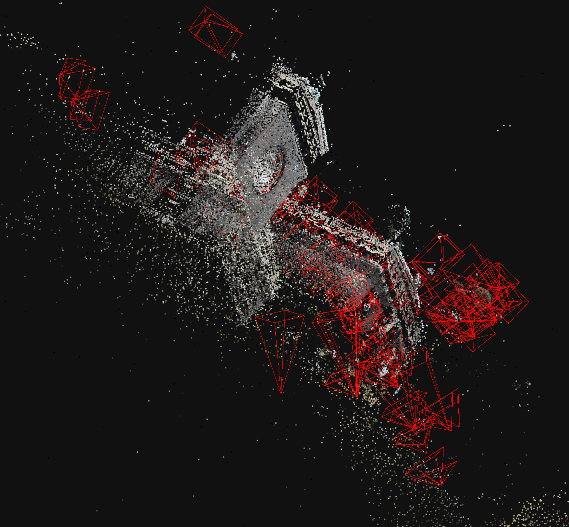

In [ ]:
print(rec_gt)
print()

fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, maps[best_index], color='rgba(0,255,255,0.5)', name="Reconstruction", cs=5)
viz_3d.plot_reconstruction(fig, rec_gt, points=False, color='rgba(0,100,0,0.1)', name="GT Reconstruction", cs=5)
fig.show()

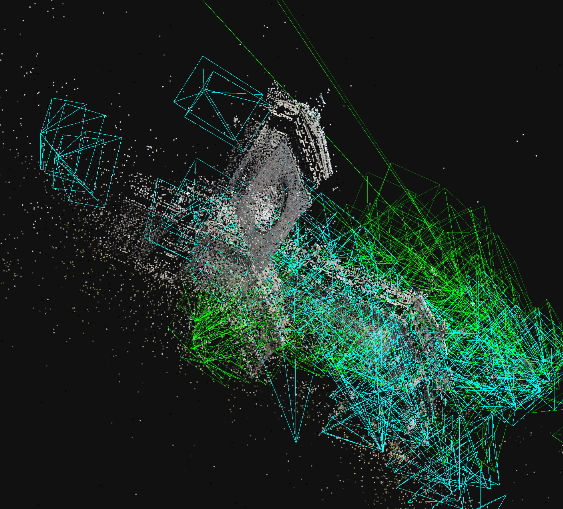